## Introduction:
The function of this notebook is to take a video of ants (or other creatures) moving about an environment and to extract a series of points for each route for use in further experiments.

Recording where the ants are in any one frame is as simple as comparing the frame with an image of the empty environment. The differences can be expressed as a posterised image and the centres of each area of difference can be calculated.<br>
The challenge is when you have two consecutive frames of a video with the points changing location between them. How do you identify which ant has moved to which new location?

We will use the Lucas-Kanade optical flow algorithm which reads the direction of flow of a cluster of pixels between two images and estimates where a point from the first image would now lie.<br>
Through being able to keep track of which locations correspond to individual subjects thoroughout a video we will be able to carry out more detailed studies of their behaviour later.

This method is not perfect as when two subjects come together the algorithm can wrongly assign points as they separate. Over time, points get left behind in some 'dark' areas of the board or ants pick up multiple points.<br>
As we are more concerned with the activity of the whole colony rather than the individuals we can compensate for this by resetting the points every 15 seconds or so. This balances getting information about routes and individuals with accurate information about the colony in the long run.

## Start:
First we import the required modules and set matplotlib to display images in-line throughout the document.

In [115]:
import numpy as np
import imutils
import cv2
import pandas as pd
from datetime import datetime
import IPython
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]

In [116]:
cv2.__version__

'3.4.0'

Next we import the video and a blank image of the environment.<br> *(This can be created using the 'BackgroundCreator' script)*

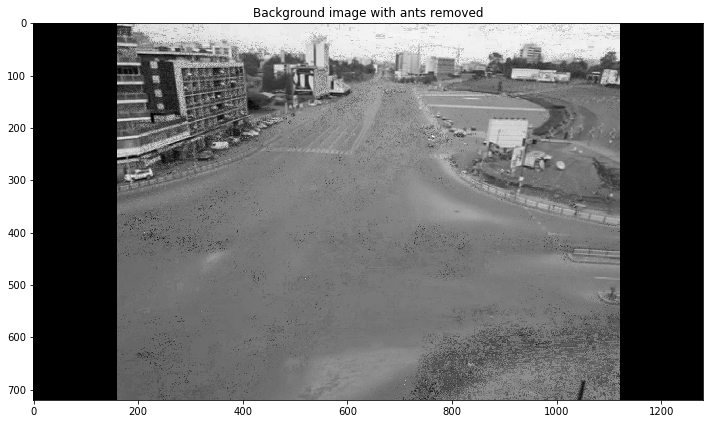

In [117]:
vidname = 'Crossing 01'
cap = cv2.VideoCapture(vidname+'.mp4')
bgnd = cv2.imread(vidname+'_bgnd.png', cv2.IMREAD_GRAYSCALE)  # '0' brings in grayscale image
plt.imshow(bgnd, cmap=plt.cm.gray); plt.title('Background image with ants removed');

Next we create the first set of parameters for use in different sections below. The purpose and function of each is described in in-line comments.

In [118]:
# Get the current date and time for unique naming of outputs.
current_time = datetime.now().strftime('%Y-%m-%d %H%M%S')

# Create some random colors for colouring the routes
color = np.random.randint(0, 255, (3000, 3))

# Parameters for resizing and blurring images so the difference between them can be seen more clearly
resize = 1000 # This sets the width of the frame and scales the height proportionally
blur_amt = (15, 15) # Each number is the amount of blur in the x and y direction

# This sets a point between 0-100 where a gradiated grey image is split into black and white
thresh_val = 20

# How many times to fill a thresholded image to make it whole
dilations = 2

# Set the size below which we wont save the location of a contour
radsize = 20

# Parameters for the Lucas-Kanade optical flow algorithm: 
# How wide to search for movement, how many levels of calculation to carry out, criteria for evaluating success
lk_params = dict(winSize=(15, 15), maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                           10, 0.001))

The first function we create converts an image to grayscale and blurs it for smoother  comparison with other frames.

In [119]:
def gray_blur(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayblur = cv2.GaussianBlur(gray, blur_amt, 0)
    return grayblur

The next function takes two images *(i.e. a video frame and the blank environment image)* and produces:
1. A list of contours outlining the areas of differences between the two images
2. A mask showing these areas of difference as a two tone image

In [120]:
def make_contours(image, background):
    # convert it to grayscale, and blur it
    gb_image = gray_blur(image)

    # compute the absolute difference between the current frame and first frame.
    # Second parameter sets lower boundary of threshold
    framedelta = cv2.absdiff(background, gb_image)
    _, thresh = cv2.threshold(framedelta, thresh_val, 255, cv2.THRESH_BINARY)

    # dilate the thresholded image to fill in holes, then find contours
    thresh = cv2.dilate(thresh, None, iterations=dilations)
    (_, conts, _) = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return conts, thresh

We now create a function which takes a set of contours and calculates their centre points.<br>
It then draws those points on a given image and saves them to a given list.

In [121]:
def contour_centroids(conts, image, lst):
    # loop over the contours
    for con in conts:
        ((x, y), radius) = cv2.minEnclosingCircle(con)
        center = (int(x), int(y))

        # only proceed if the radius meets a minimum size
        if radius > radsize:
            # draw the circle bounding the area
            cv2.circle(image, center, int(radius), (0, 255, 255), 2)
            cv2.circle(image, center, 3, (0, 0, 255), -1)
            lst.append(center)

To begin the process we create a blurred background image to read movement against.<br> *(We dont use the 'gray_blur' function here as the image was already brought in in grayscale.)*

In [122]:
bgnd_frame = imutils.resize(bgnd, width=resize)
bgnd_frame = cv2.GaussianBlur(bgnd_frame, blur_amt, 0)

Using the above two functions 'make_contours' and 'contour_centroids' we now create a set of points and a starter image of just the ant's outlines to kick-off the tracking process. <br>
The points list is reformatted as a 3d array as that is what the tracking algorithm requires as an input.

Locations of ants in pixel values:
[(615, 541), (229, 534), (650, 505), (167, 525), (453, 492), (745, 500), (164, 461), (284, 445), (835, 428), (601, 371), (360, 369), (554, 335), (750, 318), (853, 307), (143, 297), (193, 270), (256, 276), (452, 308), (403, 239), (510, 162), (250, 153), (432, 70)]


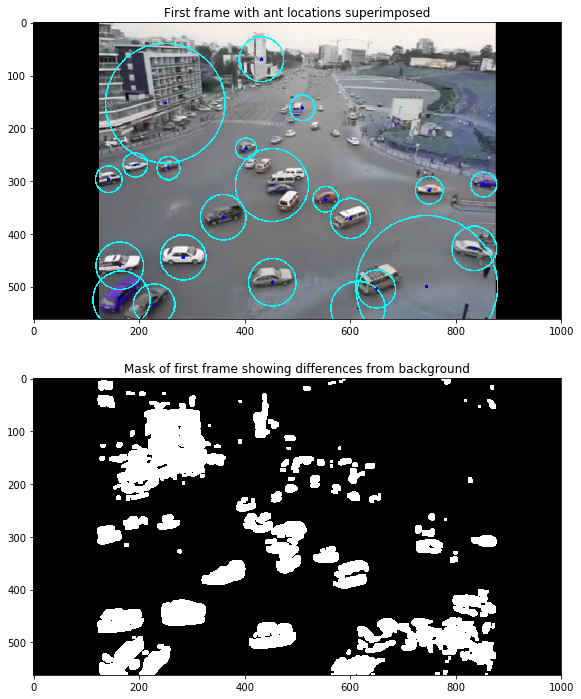

In [123]:
# get first frame of video
_, first_frame = cap.read()

# create list of first points
points = []
sized_first_frame = imutils.resize(first_frame, width=resize)
first_conts, first_gray = make_contours(sized_first_frame, bgnd_frame)
contour_centroids(first_conts, sized_first_frame, points)

# convert the points to a 3d array for the optical flow tracker
p0 = np.array(points, dtype=np.float32, ndmin=3)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
ax1.imshow(sized_first_frame); ax1.set_title('First frame with ant locations superimposed')
ax2.imshow(first_gray, cmap=plt.cm.gray); ax2.set_title('Mask of first frame showing differences from background')
print("Locations of ants in pixel values:")
print(points)

Before we start to loop over the frames of the video we need to create a couple of frames to write over and save out.

We also create two counters to track and adjust the recording process and a dict to store recorded points in.

In [124]:
# create a copy of the first frame for output
printFrame = first_gray.copy()

# create mask size of original frame for use in loop
mask = np.zeros_like(first_frame)
mask = imutils.resize(mask, width=resize)

# Create dict and lists to store points recorded, count frames and count resets
pointsdict = {}
framecount = 1
resets = 1

We now loop over the frames of the video to track points. The key steps of this are:
1. Take the current frame and compare it to the background to highlight current ant positions
2. Use the optical flow algorithm to predict which ants are which from the previous frame
3. Update and display an image of the routes tracked to date
4. Save new points out to the previously created dict
5. Save the image and points for comparison against the next frame
    5. If this is a designated reset frame a new generation of points are created from scratch. This is to compensate for points that become lost as ants overlap.*

Number of routes recorded: 1286
Number of generations recorded: 69


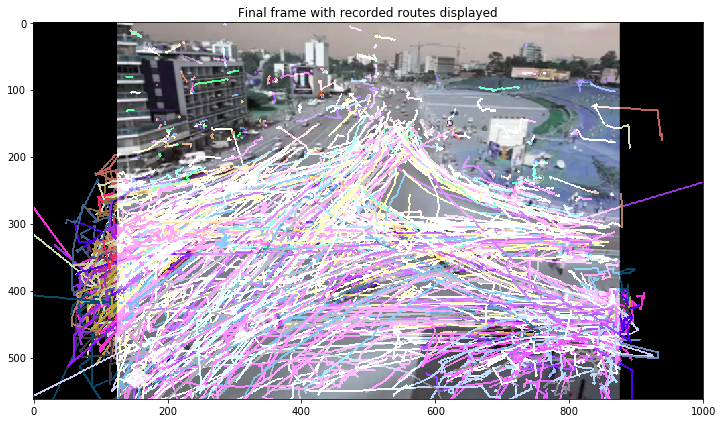

In [125]:
while True:
    # grab the current frame. If cant be read we've reached video end
    (grabbed, frame) = cap.read()
    if not grabbed:
        break

    # convert to grayscale and resize
    frame = imutils.resize(frame, width=resize)
    new_conts, frame_gray = make_contours(frame, bgnd_frame)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(first_gray, frame_gray, p0,
                                           None, **lk_params)

    # Select good points (if comprehension not complete points wont be rejected)
    good_new = [x for x, y in zip(p1[0], st) ] #if y == 1]
    good_new = np.array(good_new)

    good_old = [x for x, y in zip(p0[0], st)]  # if y == 1]
    good_old = np.asarray(good_old)

    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
        frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), 1)

    # add the lines and points to the image
    img = cv2.add(frame, mask)
    printFrame = img
    cv2.imshow('frame', img)
    cv2.imshow('thresh', frame_gray)

    # create lists to store points generated
    for i, new in enumerate(good_new):
        pt = new.tolist()
        try:
            pointsdict[str(resets)+":"+str(i)].append(pt)
        except KeyError:
            pointsdict[str(resets)+":"+str(i)] = []
            pointsdict[str(resets)+":"+str(i)].append(pt)

    # Now update the previous frame and previous points
    # set a framecount at which point to reset the points (450 = 15 seconds)
    first_gray = frame_gray.copy()

    new_points = []
    if framecount % 30 == 0:
        contour_centroids(new_conts, img, new_points)
        p0 = np.array(new_points, dtype=np.float32, ndmin=3)
        resets += 1
    else:
        p0 = np.array(good_new, dtype=np.float32, ndmin=3)

    framecount += 1

    # if the `q` key is pressed, break from the lop
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
        
# cleanup the camera and close any open windows
cap.release()
cv2.destroyAllWindows()

print("Number of routes recorded:", len(pointsdict))
print("Number of generations recorded:", resets)
plt.imshow(img); plt.title('Final frame with recorded routes displayed');

In [126]:
print(pointsdict["1:0"])

[[620.4668579101562, 532.324462890625], [608.8643188476562, 506.7113037109375], [609.4849243164062, 505.75152587890625], [609.7125244140625, 505.48291015625], [609.72412109375, 505.4571228027344], [609.5174560546875, 505.66497802734375], [609.781005859375, 507.8878479003906], [610.212890625, 509.688232421875], [609.8505859375, 509.7419738769531], [609.1978149414062, 508.670654296875], [609.7306518554688, 506.8008728027344], [608.140380859375, 506.3924560546875], [605.8924560546875, 506.99755859375], [609.5284423828125, 504.7738952636719], [625.824951171875, 499.1408996582031], [634.6754760742188, 496.5307922363281], [643.31494140625, 492.8876647949219], [672.5239868164062, 482.10772705078125], [666.8117065429688, 485.48065185546875], [669.2757568359375, 485.1767883300781], [670.2017822265625, 485.22784423828125], [702.2927856445312, 475.8287658691406], [703.6387939453125, 476.6944885253906], [737.86767578125, 469.0008544921875], [791.3680419921875, 470.16729736328125], [795.7822265625,

Save an image of the routes recorded

In [127]:
outputfile = vidname+"_"+current_time+".png"
cv2.imwrite(outputfile, printFrame)

True

Finally we convert the points dict into a dataframe and reformat this as a dataframe with a single column with all points for one segment of one subject as a list.<br>
We save out the resultant dataframe as a pickle file for use in other scripts.

In [128]:
df = pd.DataFrame.from_dict(pointsdict, orient="index")
df = df.astype('object')

# combine points visited into a single cell and drop the original columns
df['Points Visited'] = df.values.tolist()
df2 = df['Points Visited']
print("The first five rows of the resulting dataframe:")
print(df2.head(5))

# save the points data as a pickle file
df2.to_pickle(vidname+"_routelist.pkl")

The first five rows of the resulting dataframe:
1:0    [[620.4668579101562, 532.324462890625], [608.8...
1:1    [[238.57005310058594, 523.5123901367188], [244...
1:2    [[662.5611572265625, 501.0319519042969], [676....
1:3    [[168.04901123046875, 523.5579833984375], [169...
1:4    [[463.83685302734375, 489.64288330078125], [47...
Name: Points Visited, dtype: object
